In [2]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats

# Attempt to track numpy warnings... not sure if it works
# import warnings
# warnings.filterwarnings('error')

from multihist import Hist1d, Histdd

In [3]:
# Digitizer sample size
dt = 2

# Waveform time labels (center of digitizer bins). S1 and SPE waveforms will use the same time range.
valid_t_range = (-100, 300)
spe_ts = np.linspace(0, 639*2, 640) - 340 * 2
t_mask = (valid_t_range[0] <= spe_ts) & (spe_ts < valid_t_range[1])
spe_ts = spe_ts[t_mask]

# Edges of digitizer time bins.
spe_t_edges = np.concatenate([[spe_ts[0] - dt/2], spe_ts + dt/2])

default_params = dict(
    t1 = 3.1,    # Nest 2014 p2
    t3 = 24,     # Nest 2014 p2
    fs = 0.2,
    tts = 3,
    s1_min=50,
    s1_max=100,
    dset='er',
    pulse_model=1,
)

def get_params(params):
    """Fill params with the default parameters, and check for unphysical values"""
    for k, v in default_params.items():
        params.setdefault(k, v)
    if params['tts'] < 0:
        params['tts'] = 1e-6
    return params

# Load PMT pulses

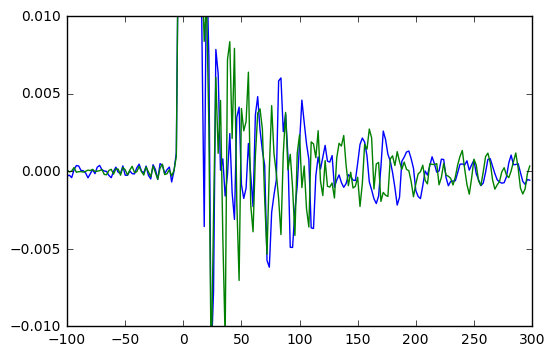

In [5]:
import pickle
from scipy.interpolate import interp1d


spe_ys = []            # Normalized SPE pulse models
spe_pulses_cum = []    # Cumulative " " " 
for ch, fn in enumerate(['170323_103732', '170323_104831']):
    with open('%s_ch%d.pickle' % (fn, ch) , 'rb') as infile:
        ys = pickle.load(infile)[t_mask]
    plt.plot(spe_ts, ys/ys.sum())
    spe_ys.append(ys/ys.sum())
    spe_pulses_cum.append(
        interp1d(spe_ts, np.cumsum(ys)/ys.sum())
    )

    plt.ylim(-0.01, 0.01)

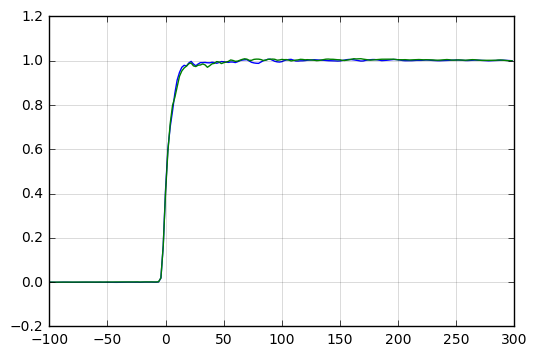

In [6]:
for ch, p in enumerate(spe_pulses_cum):
    plt.plot(spe_ts, p(spe_ts))
plt.grid(alpha=0.2, linestyle='-')

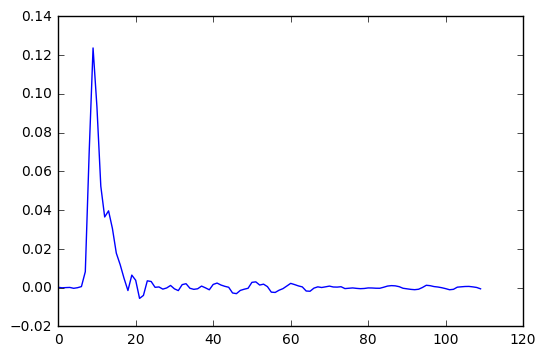

In [10]:
# Unfortunately this function doesn't accept keyword arguments (Memoize decorator limitation)
# custom_pmt_pulse_current(pmt_pulse, offset, dt, samples_before, samples_after)
# Try changing offset to get differently binned pulses
from pax.simulation import custom_pmt_pulse_current
plt.plot(custom_pmt_pulse_current(spe_pulses_cum[0], 0.1, 2, 10, 100))

# S1 model

## Simulation

In [16]:
import numba

def split_s1_groups(x, n_x, s1_min, s1_max):
    """Splits x into groups with uniform(s1_min, s1_max) elements, then return matrix of histograms per group.
    Returns: integer array (n_x, n_groups)
    n_x: number of possible values in x. Assumed to be from 0 ... n_x - 1
    s1_min: minimum S1 number of hits
    s1_max: maximum S1 number of hits
    """
    # We want to exhaust the indices x. Simulate a generous amount of S1 sizes
    n_s1_est = int(1.5 * 2 * len(x) / (s1_min + s1_max))
    hits_per_s1 = np.random.randint(s1_min, s1_max, size=n_s1_est)
    
    result = np.zeros((n_x, n_s1_est), dtype=np.int)
    s1_i = _split_s1_groups(x, hits_per_s1, result)
    return result[:,:s1_i - 1]

@numba.jit(nopython=True)
def _split_s1_groups(x, hits_per_s1, result):
    # Inner loop of split_s1_groups
    s1_i = 0
    for i in x:
        if hits_per_s1[s1_i] == 0:
            s1_i += 1
            continue
        result[i, s1_i] += 1
        hits_per_s1[s1_i] -= 1
    return s1_i 

# %%timeit
# split_s1_groups(np.random.randint(0, 100, size=int(1e6)), 101, 10, 20)

def shift(x, n):
    """Shift the array x n samples to the right, adding zeros to the left."""
    if n > 0:
        return np.pad(x, (n, 0), mode='constant')[:len(x)]
    else:
        return np.pad(x, (0, -n), mode='constant')[-len(x):]


def simulate_s1_pulse(n_photons=int(2e5), **params):
    """Return (wv_matrix, time_matrix, t_shift vector) for simulated S1s, consisting of n_photons in total
     * wv_matrix and time_matrix have shape (n_samples, n_s1s). t_shift_vector has shape (n_s1s).
     * wv_matrix contains amplitude, time_matrix contains center time of digitizer bin to which amplitude applies
     * t_shift_vector contains, for each S1, the time shift applied to align it. 
       e.g. for alignment on maximum, the time between the interaction time and the maximum time.
    """
    params = get_params(params)

    ##
    # Make matrix (n_samples, n_waveforms) of pulse waveforms with various shifts
    ##
    i_noshift = np.searchsorted(spe_t_edges, [0])[0]    # Index corresponding to no shift in the waveform
    y = spe_ys[params['pulse_model']]
    wv_matrix = np.vstack([shift(y, i - i_noshift) 
                           for i in range(len(spe_ts))]).T
    
    ##
    # Simulate S1 pulse times, convert to index
    ##
    times = np.zeros(n_photons)

    n_singlets = np.random.binomial(n=n_photons, p=params['fs'])

    times += np.concatenate([
        np.random.exponential(params['t1'], n_singlets),
        np.random.exponential(params['t3'], n_photons - n_singlets)
    ])

    np.random.shuffle(times)

    times += np.random.normal(0, params['tts'], size=n_photons)

    indices = np.searchsorted(spe_t_edges, times)
    
    # TODO: gain variation simulation

    ##
    # Build instruction matrix, simulate waveforms
    ##
    index_matrix = split_s1_groups(indices, len(spe_t_edges) - 1, params['s1_min'], params['s1_max'])
    n_s1 = index_matrix.shape[1]
    s1_waveforms = np.dot(wv_matrix, index_matrix)

    ##
    # Align, compute average pulse
    ##
    time_matrix, t_shift = aligned_time_matrix(spe_ts, s1_waveforms)    
    return s1_waveforms, time_matrix, t_shift

def aligned_time_matrix(ts, wv_matrix):
    """Return time matrix that would align waveforms im wv_matrix
      ts: array of (n_samples), center times of digitizer bins
      wv_matrix: (n_s1s, n_samples) amplitudes
    """
    n_s1 = wv_matrix.shape[1]
    t_shift = ts[np.argmax(wv_matrix, axis=0)]
    time_matrix = np.repeat(ts, n_s1).reshape(wv_matrix.shape)
    time_matrix -= t_shift[np.newaxis,:]
    return time_matrix, t_shift

def average_pulse(time_matrix, wv_matrix):
    """Return average pulse, given time and waveform matrices
    Both are (n_s1s, n_samples) matrices, see simulate_s1_pulse
    """
    h, _ = np.histogram(time_matrix, bins=spe_t_edges, weights=wv_matrix)
    h /= h.sum()
    return h

def s1_average_pulse_model(*args, **kwargs):
    """Return average S1 pulse for given model parameters"""
    wv_matrix, time_matrix, _ = simulate_s1_pulse(*args, **kwargs)
    return average_pulse(time_matrix, wv_matrix)


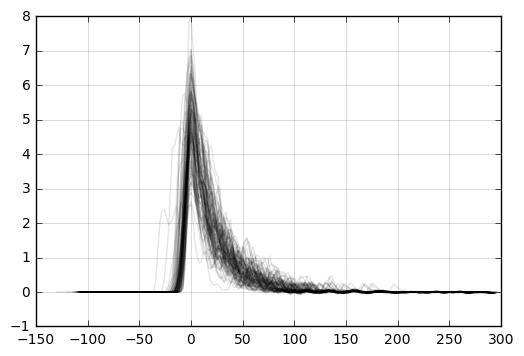

In [17]:
s1_wvs, tmat, _ = simulate_s1_pulse()
for i in range(100):
    plt.plot(tmat[:, i], s1_wvs[:, i], alpha=0.1, c='k')
plt.grid(alpha=0.2, linestyle='-')

## Statistical errors

In [18]:
def s1_models_resample(*args, n_data_s1s=1000, bootstrap_trials=10, **kwargs):
    """Return waveform templates built by repeated sampling of n_data_s1s s1s
    Returns: (n_samples, n_templates) matrix of waveform templates.
    """
    wv_matrix, time_matrix, _ = simulate_s1_pulse(*args, **kwargs)
    n_s1s = wv_matrix.shape[1]
    
    waveform_templates = np.zeros((len(spe_ts), bootstrap_trials))

    for i in range(bootstrap_trials):
        new_indices = np.random.randint(n_s1s, size=n_data_s1s)

        waveform_templates[:, i] = average_pulse(time_matrix[:, new_indices], 
                                                 wv_matrix[:, new_indices])
    
    return waveform_templates

def sigmas_plot(x, q, color='b', **kwargs):
    """Plot median and +- 1 sigma percentiles for axis 1 of q, versus x
     x: array (n_samples), x-axis labels
     q: array (n_samples, n_whatever)
    kwargs are passed to plt.plot for the median. Use e.g. for a label.
    """
    for n_sigma, alpha in [(1,0.5), (2, 0.1)]:
        plt.fill_between(x,
                         np.percentile(q, 100 * stats.norm.cdf(-n_sigma), axis=1),
                         np.percentile(q, 100 * stats.norm.cdf(n_sigma), axis=1),
                         alpha=alpha, linewidth=0, color=color, step='mid')
    plt.plot(x, 
             np.percentile(q, 50, axis=1), 
             color=color, linestyle='-', alpha=0.5, linewidth=1, **kwargs)

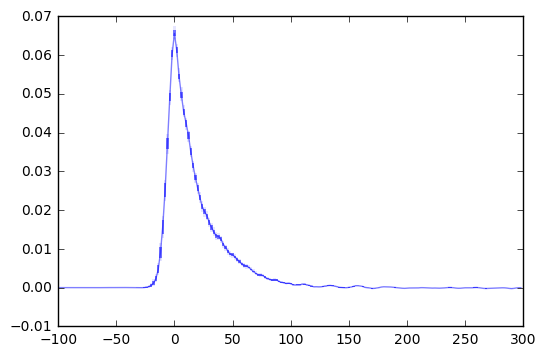

In [20]:
waveform_templates = s1_models_resample(n_data_s1s=100, s1_min=50, s1_max=100, bootstrap_trials=100)
sigmas_plot(spe_ts, waveform_templates)

Statistical errors are negligible if you have more than a few hundred waveforms.

## Systematic errors

In [22]:
import itertools

def s1_models_error(*args, shifts=None, **kwargs):
    """Return (minimum, base, maximum) of waveform models obtained by varying pulse model by shifts.
      kwargs: parameters of base model
      shifts: dictionary of shifts to consider. Format:
          key: value      key is parameter, value is amplitude of shift from base value (+ and - will be tried)
          key: [values]   key is parameter, values are possible values we will try.
    """
    if shifts is None:
        shifts = dict(tts=1, pulse_model=[0,1])
    
    base_model = s1_average_pulse_model(*args, **kwargs)
    
    # Allow specifying a single +- amplitude of variation
    for p, shift_values in shifts.items():
        if isinstance(shift_values, (float, int)):
            shifts[p] = kwargs.get(p, default_params[p]) + np.array([-1, 0, 1]) * shift_values
    
    shift_pars = sorted(shifts.keys())
    shift_values = [shifts[k] for k in shift_pars]
    shift_value_combs = list(itertools.product(*shift_values))
    
    alt_models = []
    for vs in shift_value_combs:
        kw = dict()
        kw.update(kwargs)
        for i, p in enumerate(shift_pars):
            kw[p] = vs[i]
        # print(kw)
        
        alt_models.append(s1_average_pulse_model(*args, **kw))
    
    
    alt_models = np.vstack(alt_models)
    minus = np.min(alt_models, axis=0)
    plus = np.max(alt_models, axis=0)    
    return minus, base_model, plus


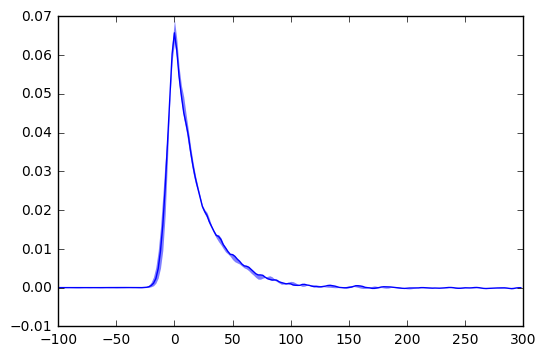

In [23]:
minus, base, plus = s1_models_error()
plt.fill_between(spe_ts, minus, plus, alpha=0.5, linewidth=0)
plt.plot(spe_ts, base)

# Real data waveforms

In [25]:
# Get XAMS data from Erik's file
xams_data = dict()
xams_data['nr'], xams_data['er'], xams_data['bg_nr'] = pickle.load(open('highfield_dataframes.pickle', 'rb'))

# Create a dictionary mapping data_key : matrix of (n_samples, n_s1s)
xams_s1s = dict()
for k, d in xams_data.items():
    xams_s1s[k] = np.array([x for x in d['s1_pulse']])
    del d['s1_pulse']    # Bye bye object column!

In [26]:
def real_s1_wv(**params):
    """Return average S1 waveform, number of S1s it was constructed from"""
    params = get_params(params)
    
    areas = xams_data[params['dset']]['s1'].values
    mask = (params['s1_min'] < areas) & (areas < params['s1_max'])

    # Could now derive distribution, I'll just assume uniform for the moment.
    # Hist1d(areas[mask],
    #        bins=np.linspace(params['s1_min'], params['s1_max'], 100)).plot()

    n_data_s1s = mask.sum()
    wvs = xams_s1s[params['dset']][mask].T
    tmat, _ = aligned_time_matrix(spe_ts, wvs)
    real_s1_avg =  average_pulse(tmat, wvs)
    
    return real_s1_avg, n_data_s1s

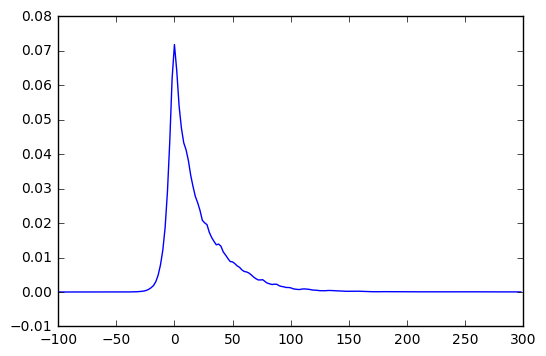

In [27]:
ydata, n_data_s1s = real_s1_wv()
plt.plot(spe_ts, ydata)

# Model-data comparison

## Plotting

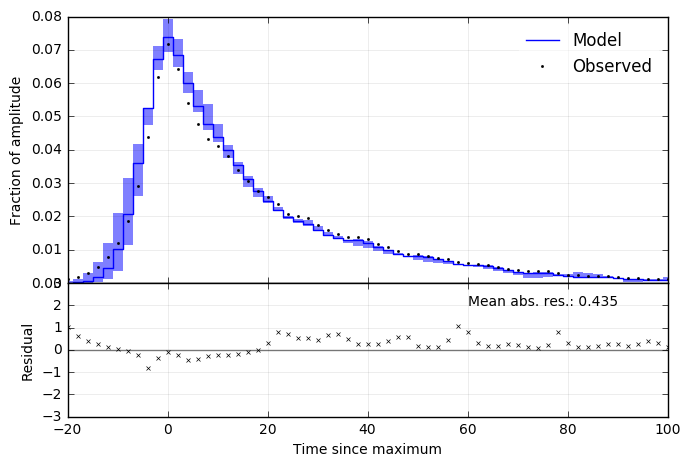

In [28]:
def residuals(ydata, minus, base, plus):
    return (ydata - base)/np.abs(plus - minus)/2

def comparison_plot(ydata, minus, base, plus):
    """Compare data-extracted model ydata against (minimum, base, maximum) of models returned by s1_models_error"""
    # large subplot
    ax2 = plt.subplot2grid((3,1), (2,0))
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

    #f, (ax1, ax2) = plt.subplots(2, sharex=True)
    plt.sca(ax1)
    plt.fill_between(spe_ts, minus, plus, alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, base, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=0.1, linestyle='-', which='both')
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    leg = plt.legend(loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    plt.ylim(0, None)

    #ax1.set_xticklabels([])

    # Add residuals
    plt.sca(ax2)
    plt.subplot2grid((3,1), (2,0), sharex=ax1)
    plt.xlim(-20, 100)

    res = residuals(ydata, minus, base, plus)
    
    plt.plot(spe_ts, res,
             linestyle='', marker='x', c='k', markersize=3)
    plt.ylim(-3, 3)
    plt.grid(which='both', linestyle='-', alpha=0.1)
    plt.axhline(0, c='k', alpha=0.5)

    plt.ylabel("Residual")
    plt.xlabel("Time since maximum")
    plt.text(#plt.xlim()[1] * 0.5, plt.ylim()[1] * 0.6,
             60, 2,
             'Mean abs. res.: %0.3f' % np.abs(res).mean())

    plt.tight_layout()
    plt.gcf().subplots_adjust(0,0,1,1,0,0)

ydata, _ = real_s1_wv()
minus, base, plus = s1_models_error(t1=2, fs=0.3)

comparison_plot(ydata, minus, base, plus)

## Fitting

In [29]:
def gof(**params):
    """Return goodness of fit of parameters. Parameters also selects which dataset to use.."""
    params = get_params(params)
    
    if params['t1'] < 0 or params['t3'] < 0 or not (0 <= params['fs'] <= 1):
        result = float('inf')
    else:
        ydata, _ = real_s1_wv(**params)
        minus, base, plus = s1_models_error(**params)
        res = residuals(ydata, minus, base, plus)
        result = np.abs(res).mean()
    print('gof={gof}, fs={fs}, t1={t1}, t3={t3}, tts={tts}'.format(gof=result, **params))    
    return result


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


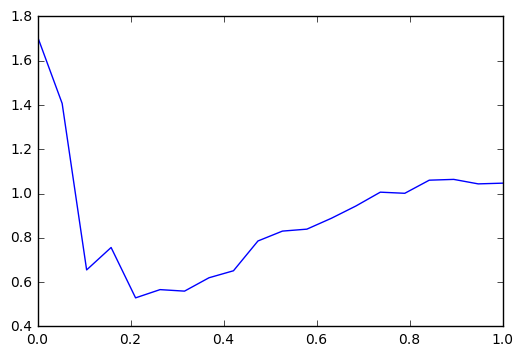

In [60]:
from tqdm import tqdm
fs = np.linspace(0, 1, 20)
gofs = [gof(fs=x) for x in tqdm(fs)]
plt.plot(fs, gofs)

In [54]:
default_params

{'dset': 'er',
 'fs': 0.2,
 'pulse_model': 1,
 's1_max': 100,
 's1_min': 50,
 't1': 3.1,
 't3': 24,
 'tts': 3}

In [74]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t3=x[1], tts=x[2]),
    [0.2, 24, 3],
    bounds=[[.01, 1], [20, 30], [.1, 5]],
    options=dict(maxfev=1000),
    method='Powell',
)

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


fs=0.2, t1=3.1, t3=24.0, tts=3.0
fs=0.2, t1=3.1, t3=24.0, tts=3.0
fs=1.2, t1=3.1, t3=24.0, tts=3.0
fs=-1.418034, t1=3.1, t3=24.0, tts=3.0
fs=0.2, t1=3.1, t3=24.0, tts=3.0
fs=-0.418033974844, t1=3.1, t3=24.0, tts=3.0
fs=0.581966, t1=3.1, t3=24.0, tts=3.0
fs=-0.036067965235263316, t1=3.1, t3=24.0, tts=3.0
fs=0.34589802515600004, t1=3.1, t3=24.0, tts=3.0
fs=0.3150501448856938, t1=3.1, t3=24.0, tts=3.0
fs=0.2922504361877629, t1=3.1, t3=24.0, tts=3.0
fs=0.3162006463445507, t1=3.1, t3=24.0, tts=3.0
fs=0.32754403533964477, t1=3.1, t3=24.0, tts=3.0
fs=0.3211893091226332, t1=3.1, t3=24.0, tts=3.0
fs=0.3183158435461937, t1=3.1, t3=24.0, tts=3.0
fs=0.3162006463445507, t1=3.1, t3=24.0, tts=3.0
fs=0.3162006463445507, t1=3.1, t3=25.0, tts=3.0
fs=0.3162006463445507, t1=3.1, t3=22.381966, tts=3.0
fs=0.3162006463445507, t1=3.1, t3=24.0, tts=3.0
fs=0.3162006463445507, t1=3.1, t3=23.381966025156, tts=3.0
fs=0.3162006463445507, t1=3.1, t3=24.381966, tts=3.0
fs=0.3162006463445507, t1=3.1, t3=24.38618179140

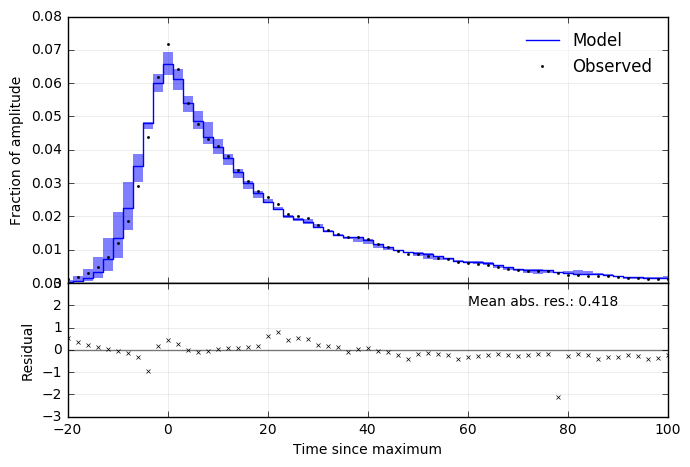

In [77]:
fit = optresult.x
ydata, _ = real_s1_wv()
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts=fit[2])
comparison_plot(ydata, minus, base, plus)

In [65]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t1=x[1], t3=x[2], tts=x[3]),
    [0.2, 3.1, 24, 3],
    bounds=[[.01, 1], [.1, 5], [20, 30], [.1, 5]],
    options=dict(maxfev=1000),
    method='Powell',
)

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


fs=0.2, t1=3.1, t3=24.0, tts=3.0
fs=0.2, t1=3.1, t3=24.0, tts=3.0
fs=1.2, t1=3.1, t3=24.0, tts=3.0
fs=-1.418034, t1=3.1, t3=24.0, tts=3.0
fs=0.2, t1=3.1, t3=24.0, tts=3.0
fs=-0.418033974844, t1=3.1, t3=24.0, tts=3.0
fs=0.581966, t1=3.1, t3=24.0, tts=3.0
fs=-0.036067965235263316, t1=3.1, t3=24.0, tts=3.0
fs=0.34589802515600004, t1=3.1, t3=24.0, tts=3.0
fs=0.23182032474189287, t1=3.1, t3=24.0, tts=3.0
fs=0.10983006359094741, t1=3.1, t3=24.0, tts=3.0
fs=0.16555815006957983, t1=3.1, t3=24.0, tts=3.0
fs=0.18684438434947714, t1=3.1, t3=24.0, tts=3.0
fs=0.20683028936553222, t1=3.1, t3=24.0, tts=3.0
fs=0.21637563321809922, t1=3.1, t3=24.0, tts=3.0
fs=0.22227498026067657, t1=3.1, t3=24.0, tts=3.0
fs=0.2127296364081096, t1=3.1, t3=24.0, tts=3.0
fs=0.21862898321056431, t1=3.1, t3=24.0, tts=3.0
fs=0.21498298640057473, t1=3.1, t3=24.0, tts=3.0
fs=0.21412228331735278, t1=3.1, t3=24.0, tts=3.0
fs=0.21551493013487727, t1=3.1, t3=24.0, tts=3.0
fs=0.21465422708668877, t1=3.1, t3=24.0, tts=3.0
fs=0.21518

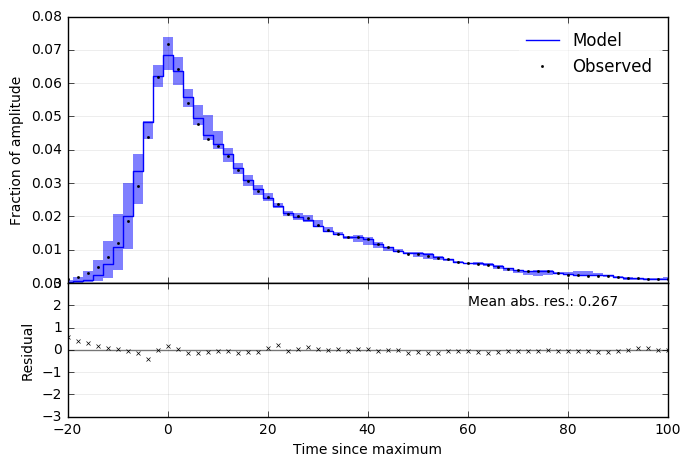

In [72]:
fit = optresult.x
ydata, _ = real_s1_wv()
minus, base, plus = s1_models_error(fs=fit[0], t1=fit[1], t3=fit[2], tts=fit[3])
comparison_plot(ydata, minus, base, plus)